# FlexPower Quant Challenge - Task 1 analysis
Check task 1 implementation

In [1]:
from task1 import *

In [2]:
# Task 1.1: Check total buy/sell volume functions
import sqlite3
from pathlib import Path

# Test the volume functions
total_buy = compute_total_buy_volume()
total_sell = compute_total_sell_volume()

print("=== Task 1.1: Total Buy/Sell Volume ===")
print(f"Total buy volume: {total_buy:.2f} MW")
print(f"Total sell volume: {total_sell:.2f} MW")
print(f"Net position: {total_buy - total_sell:.2f} MW")

# Task 1.2: Check PnL function for each strategy
print("\n=== Task 1.2: Strategy PnL ===")
db_path = Path(__file__).resolve().parent / "trades.sqlite" if '__file__' in dir() else Path("trades.sqlite")
with sqlite3.connect(db_path) as conn:
    strategies = [row[0] for row in conn.execute(
        "SELECT DISTINCT strategy FROM epex_12_20_12_13"
    ).fetchall()]
    
    total_pnl = 0
    for strat in strategies:
        pnl = compute_pnl(strat)
        total_pnl += pnl
        print(f"  {strat}: {pnl:.2f} EUR")
    
    print(f"\nTotal PnL across all strategies: {total_pnl:.2f} EUR")

# Task 1.3: Check API (would require running the FastAPI app)
print("\n=== Task 1.3: API Check ===")
print("FastAPI app is defined in task1.py")
print("To test the API, run: uvicorn task1:app --reload")
print("Then visit: http://localhost:8000/v1/pnl/{strategy_id}")
print("Or use: http://localhost:8000/docs for interactive API documentation")

=== Task 1.1: Total Buy/Sell Volume ===
Total buy volume: 28.00 MW
Total sell volume: 53.00 MW
Net position: -25.00 MW

=== Task 1.2: Strategy PnL ===
  strategy_1: -50.00 EUR
  strategy_2: 548.00 EUR

Total PnL across all strategies: 498.00 EUR

=== Task 1.3: API Check ===
FastAPI app is defined in task1.py
To test the API, run: uvicorn task1:app --reload
Then visit: http://localhost:8000/v1/pnl/{strategy_id}
Or use: http://localhost:8000/docs for interactive API documentation


# FlexPower Quant Challenge - Task 2 analysis
Uses `task2_analysis.py` helpers to reproduce the calculations and plots.

In [4]:
from task2_analysis import (
    load_data, task2_1_totals, task2_2_profiles, task2_3_values,
    task2_4_extremes, task2_5_weekday_weekend, task2_6_battery_revenue,
    run_strategy
)

df = load_data()
df.head()

,hour,time,wind_da,wind_id,pv_da,pv_id,da_price,id_price_qh,id_price_h,imb_price_qh,timestamp,date,minute,wind_da_mwh,wind_id_mwh,pv_da_mwh,pv_id_mwh
0,0,2021-01-01 00:00:00,4433,4709,0,0,50.87,44.409894,48.682294,13.33,2021-01-01 00:00:00,2021-01-01,0,1108.25,1177.25,0.0,0.0
1,0,2021-01-01 00:15:00,4286,4507,0,0,50.87,52.139142,48.682294,-0.92,2021-01-01 00:15:00,2021-01-01,15,1071.50,1126.75,0.0,0.0
2,0,2021-01-01 00:30:00,4142,4307,0,0,50.87,50.160255,48.682294,60.26,2021-01-01 00:30:00,2021-01-01,30,1035.50,1076.75,0.0,0.0
3,0,2021-01-01 00:45:00,3991,4181,0,0,50.87,41.342082,48.682294,-12.05,2021-01-01 00:45:00,2021-01-01,45,997.75,1045.25,0.0,0.0
4,1,2021-01-01 01:00:00,3847,4094,0,0,48.19,64.424013,46.165819,96.09,2021-01-01 01:00:00,2021-01-01,0,961.75,1023.50,0.0,0.0


In [5]:
print('Task 2.1 totals (MWh):', task2_1_totals(df))
print('Task 2.3 values (EUR/MWh):', task2_3_values(df))
print('Task 2.4 extremes:', task2_4_extremes(df))
print('Task 2.5 weekday vs weekend:', {
    'weekday_mean': task2_5_weekday_weekend(df)['weekday_mean'],
    'weekend_mean': task2_5_weekday_weekend(df)['weekend_mean'],
})

Task 2.1 totals (MWh): {'wind_da_mwh': 115395406.25, 'wind_id_mwh': 113478034.5, 'pv_da_mwh': 46094572.75, 'pv_id_mwh': 46689891.5}
Task 2.3 values (EUR/MWh): {'wind_value': 81.38963955550794, 'pv_value': 76.89453079034125, 'avg_da_price': 96.85335312250257}
Task 2.4 extremes: {'max_day': (datetime.date(2021, 3, 12), 1088041.0, 22.28625), 'min_day': (datetime.date(2021, 11, 16), 59199.25, 237.465)}
Task 2.5 weekday vs weekend: {'weekday_mean': 104.36723180076628, 'weekend_mean': 77.98435096153847}


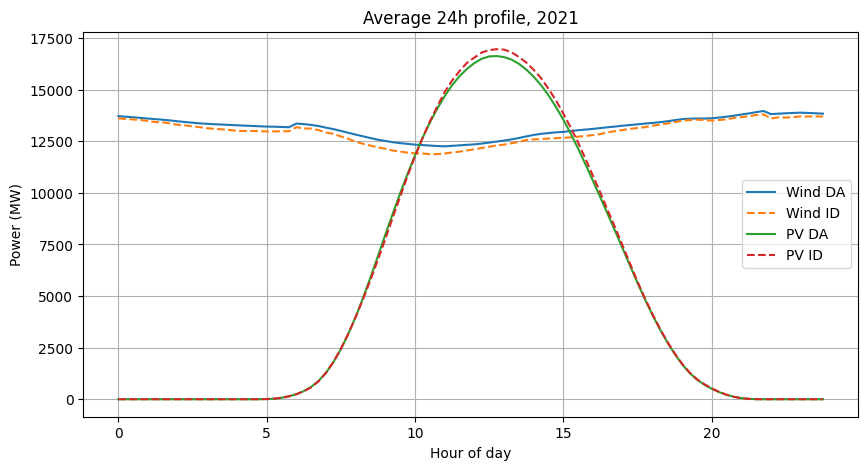

In [6]:
# Average 24h profile (Task 2.2)
import matplotlib.pyplot as plt
profile = task2_2_profiles(df)
x = profile['slot_minutes'] / 60.0
plt.figure(figsize=(10,5))
plt.plot(x, profile['wind_da'], label='Wind DA')
plt.plot(x, profile['wind_id'], label='Wind ID', linestyle='--')
plt.plot(x, profile['pv_da'], label='PV DA')
plt.plot(x, profile['pv_id'], label='PV ID', linestyle='--')
plt.xlabel('Hour of day')
plt.ylabel('Power (MW)')
plt.title('Average 24h profile, 2021')
plt.legend()
plt.grid(True)
plt.show()

## TODO add trading strategy

From the plot above, we know that forecasts change over time. Let's see how this changes over the year:

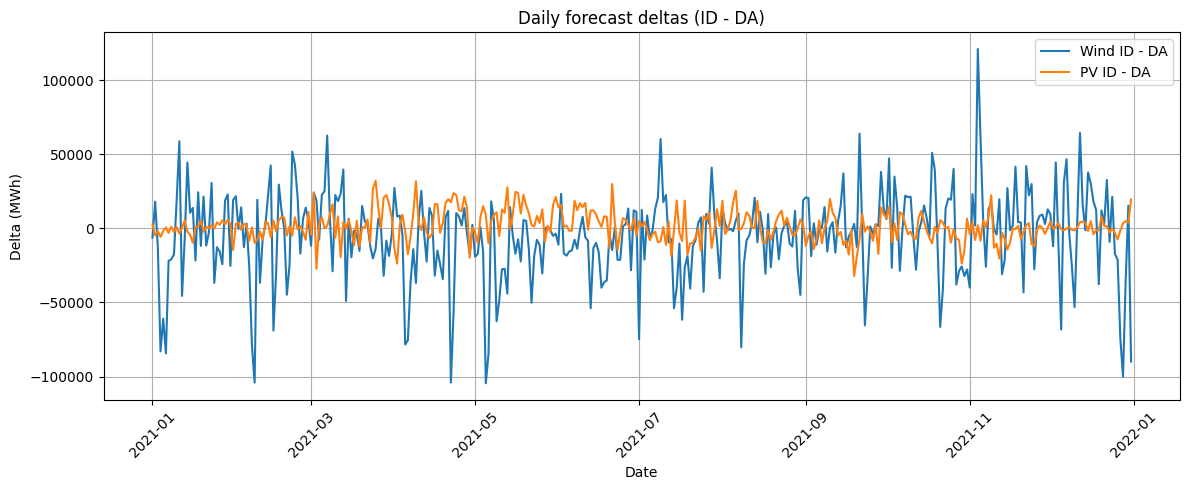

In [8]:
# Daily deltas between DA and ID forecasts
daily_delta = (
    df.groupby("date")[["wind_da_mwh", "wind_id_mwh", "pv_da_mwh", "pv_id_mwh"]]
    .sum()
    .assign(
        wind_delta=lambda d: d["wind_id_mwh"] - d["wind_da_mwh"],
        pv_delta=lambda d: d["pv_id_mwh"] - d["pv_da_mwh"],
    )
)

plt.figure(figsize=(12, 5))
plt.plot(daily_delta.index, daily_delta["wind_delta"], label="Wind ID - DA")
plt.plot(daily_delta.index, daily_delta["pv_delta"], label="PV ID - DA")
plt.title("Daily forecast deltas (ID - DA)")
plt.xlabel("Date")
plt.ylabel("Delta (MWh)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

So deviations in wind forecasts are much more volatile than for PV. No clear patter can be recognized, even though some months (e.g. May) seem to show a bias. Let's quantify this:

In [10]:
daily_delta.describe()

,wind_da_mwh,wind_id_mwh,pv_da_mwh,pv_id_mwh,wind_delta,pv_delta
count,365.000000,3.650000e+02,365.000000,365.000000,365.000000,365.000000
mean,316151.797945,3.108987e+05,126286.500685,127917.510959,-5253.073288,1631.010274
std,224975.227972,2.187065e+05,80954.426730,83514.548855,29788.247477,9951.688105
min,21004.500000,2.384000e+04,5763.500000,5739.750000,-104518.500000,-32069.250000
25%,147222.250000,1.500475e+05,46393.750000,45853.750000,-20318.000000,-3851.500000
50%,249859.000000,2.582522e+05,129128.750000,125569.500000,-1485.000000,985.750000
75%,423057.000000,4.136715e+05,187004.000000,191475.000000,12850.500000,7077.750000
max,999858.500000,1.015450e+06,311251.500000,323354.500000,120923.250000,32074.500000


So there is a bias, and the order of magnitude (~x10k GWh, daily) is not negligible. Off the back of this insight, a standard classification algorithm like XGBoost (or other decision-tree based models) should be able to capture patterns in past and present forecasts and prices, as well as future prices. They should hence be able to return us a simple yes/no probability about whether a trade should be done. That's implemented in the next cells:

XGBOOST TRADING STRATEGY: DA-ID HOURLY PRICE SPREAD PREDICTION
Position Size: 100 MW
Long Strategy: BUY Day-Ahead, SELL Intraday (when spread > 0)
Short Strategy: SELL Day-Ahead, BUY Intraday (when spread < 0)

Preparing dataset with enriched features...
Dataset shape after feature engineering: (34368, 51)
Rows dropped due to NaN: 672

 DATA LEAKAGE PREVENTION:
  - Current DA/ID prices excluded
  - Current ID forecasts excluded (not available at decision time)
  - Only DA forecasts, temporal patterns, and historical data used

Features: 27
Positive spreads (ID > DA): 17308 (50.4%)
Negative spreads (ID < DA): 17060 (49.6%)
Train set: 27494 | Test set: 6874

Training XGBoost classifier...

MODEL PERFORMANCE

Test Set Classification Report:
                 precision    recall  f1-score   support

Negative Spread       0.59      0.55      0.57      3320
Positive Spread       0.61      0.65      0.63      3554

       accuracy                           0.60      6874
      macro avg       

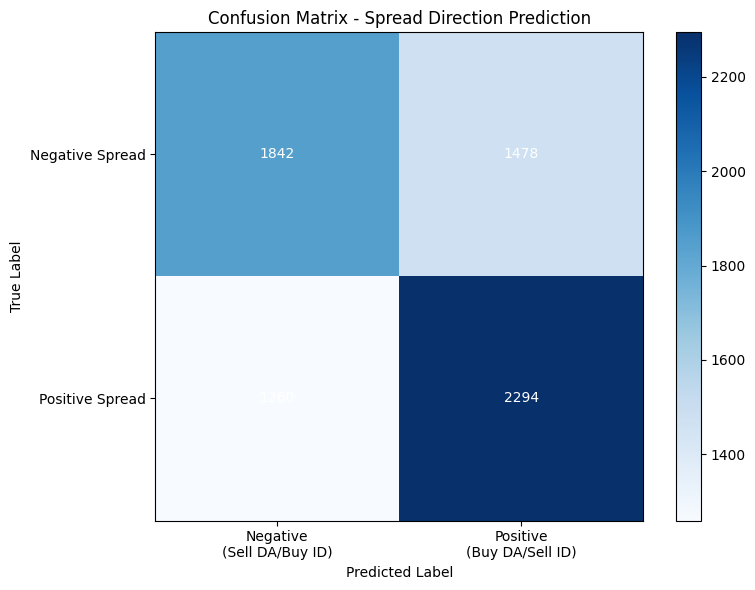

<Figure size 1000x800 with 0 Axes>

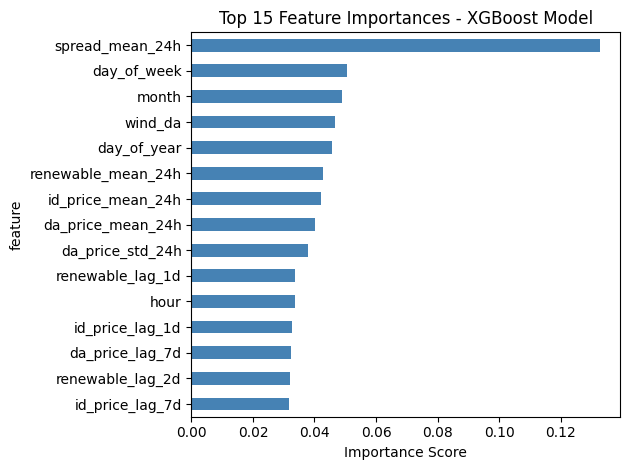


TRADING STRATEGY WITH 100 MW POSITIONS

Top 5 Strategies by Total PnL:
 long_threshold  short_threshold  long_trades  short_trades  total_trades  total_pnl_eur  avg_pnl_per_trade  win_rate
           0.50             0.60         3772          2608          6380   4.819918e+06         755.473082  0.607053
           0.75             0.60         2547          2608          5155   4.771945e+06         925.692531  0.641125
           0.50             0.55         3772          2839          6611   4.760543e+06         720.094230  0.604447
           0.50             0.50         3772          3102          6874   4.734409e+06         688.741507  0.601688
           0.80             0.60         2281          2608          4889   4.730091e+06         967.496549  0.650440

BEST STRATEGY SELECTED
Long Threshold (Buy DA/Sell ID): 0.50
Short Threshold (Sell DA/Buy ID): 0.60
Long Trades: 3772
Short Trades: 2608
Total Trades: 6380
Total PnL: 4,819,918.27 EUR
Avg PnL per Trade: 755.47 EUR
Win R

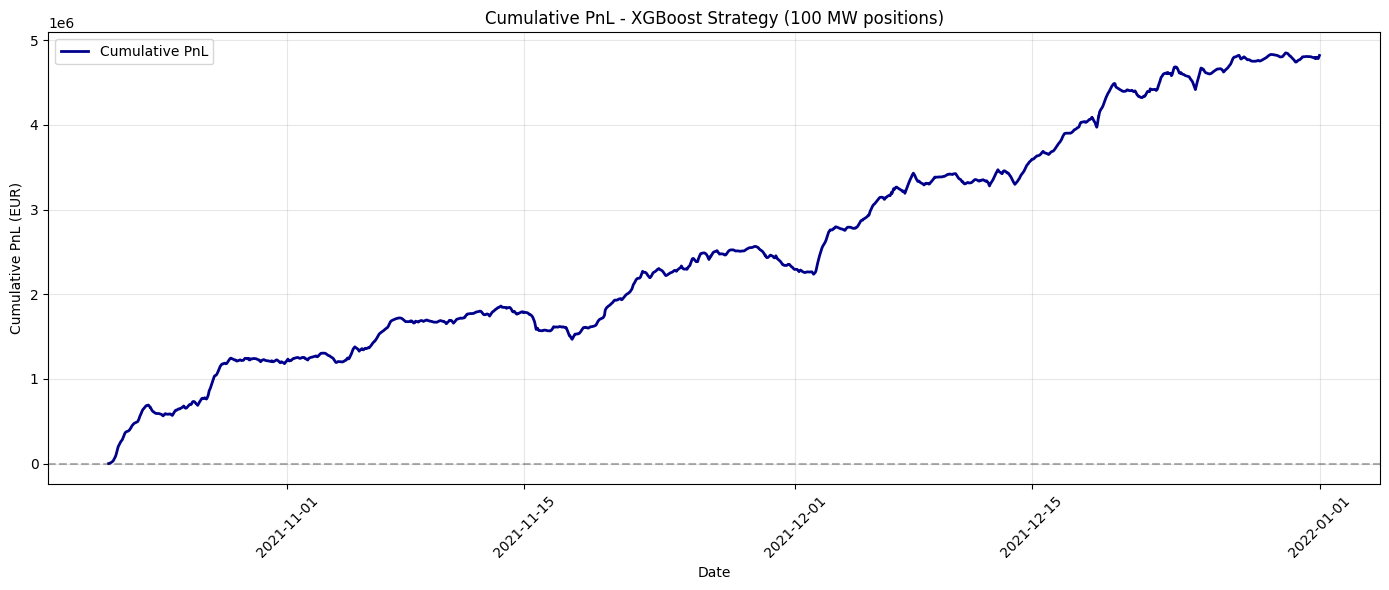


TRADING ACTIVITY BY HOUR OF DAY
      Long Trades  Short Trades  Total PnL  Avg PnL  Total Trades
hour                                                             
0             214            53  127320.24   476.85           267
1             239            30  110613.41   411.20           269
2             233            33  103925.06   390.70           266
3             236            27   22276.08    84.70           263
4             223            43  -27472.23  -103.28           266
5             213            53   31601.26   118.80           266
6             143           113  256547.53  1002.14           256
7             137           122  211066.50   814.93           259
8             139           109  248719.92  1002.90           248
9             154            97  259714.47  1034.72           251
10            189            74  212497.55   807.98           263
11            183            85  163110.07   608.62           268
12            160           115  246493.34 

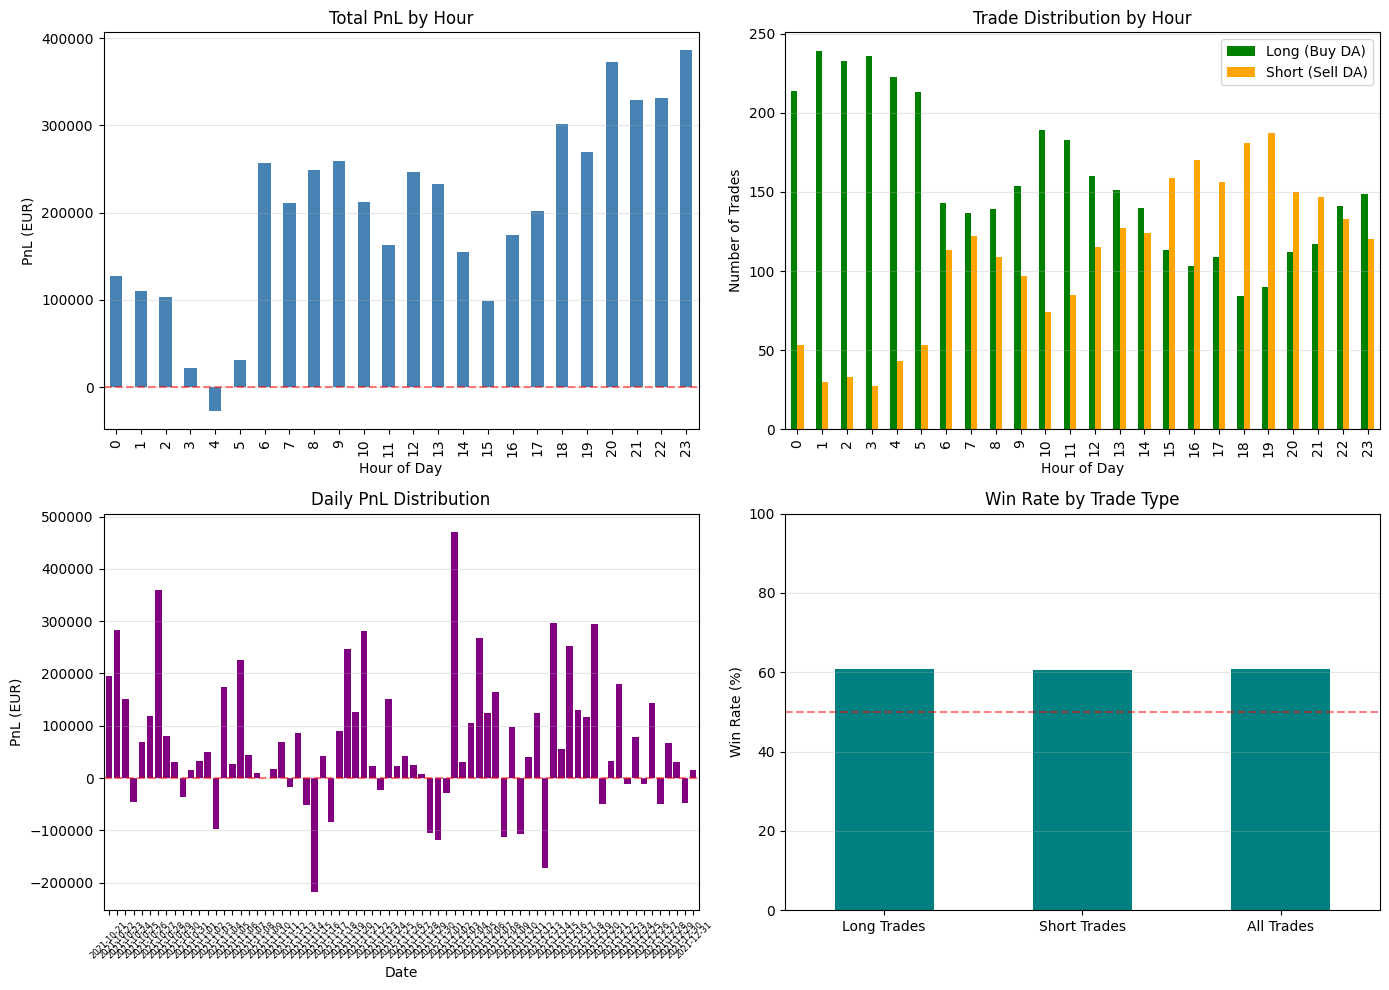

In [11]:
# Machine Learning Trading Strategy: XGBoost Model - 100 MW Position Size
# Predicts profitable DA->ID trades using enriched features and time-weighted learning
# STRATEGY: Buy DA/Sell ID when spread predicted positive, Sell DA/Buy ID when spread predicted negative

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb

POSITION_SIZE_MW = 100  # Trading position size in MW

print("="*80)
print("XGBOOST TRADING STRATEGY: DA-ID HOURLY PRICE SPREAD PREDICTION")
print("="*80)
print(f"Position Size: {POSITION_SIZE_MW} MW")
print("Long Strategy: BUY Day-Ahead, SELL Intraday (when spread > 0)")
print("Short Strategy: SELL Day-Ahead, BUY Intraday (when spread < 0)")
print("="*80)

print("\nPreparing dataset with enriched features...")

# Create enriched dataset
df_ml = df.copy()

# === TEMPORAL FEATURES ===
df_ml['timestamp'] = pd.to_datetime(df_ml['timestamp'])
df_ml['day_of_week'] = df_ml['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
df_ml['is_weekend'] = (df_ml['day_of_week'] >= 5).astype(int)
df_ml['month'] = df_ml['timestamp'].dt.month
df_ml['day_of_year'] = df_ml['timestamp'].dt.dayofyear
df_ml['hour'] = df_ml['timestamp'].dt.hour
df_ml['minute'] = df_ml['timestamp'].dt.minute
df_ml['quarter_hour'] = df_ml['hour'] * 4 + df_ml['minute'] // 15

# === RENEWABLE GENERATION FEATURES ===
df_ml['total_renewable_da'] = df_ml['wind_da'] + df_ml['pv_da']
# Note: ID renewable forecasts not used - not available at DA trading decision time

# === PRICE FEATURES ===
id_price_col = 'id_price_h'
df_ml['price_spread'] = df_ml[id_price_col] - df_ml['da_price']  # Actual spread (EUR/MWh)
df_ml['price_spread_positive'] = (df_ml['price_spread'] > 0).astype(int)  # Binary target

# === LAGGED FEATURES (previous day same hour) ===
for lag in [1, 2, 3, 7]:  # 1, 2, 3 days and 1 week ago
    lag_hours = lag * 96  # 96 quarter-hours per day
    df_ml[f'da_price_lag_{lag}d'] = df_ml['da_price'].shift(lag_hours)
    df_ml[f'id_price_lag_{lag}d'] = df_ml[id_price_col].shift(lag_hours)
    df_ml[f'spread_lag_{lag}d'] = df_ml['price_spread'].shift(lag_hours)
    df_ml[f'renewable_lag_{lag}d'] = df_ml['total_renewable_da'].shift(lag_hours)

# === ROLLING STATISTICS (past 24 hours) ===
window = 96  # 24 hours = 96 quarter-hours
df_ml['da_price_mean_24h'] = df_ml['da_price'].rolling(window=window, min_periods=1).mean()
df_ml['da_price_std_24h'] = df_ml['da_price'].rolling(window=window, min_periods=1).std()
df_ml['id_price_mean_24h'] = df_ml[id_price_col].rolling(window=window, min_periods=1).mean()
df_ml['spread_mean_24h'] = df_ml['price_spread'].rolling(window=window, min_periods=1).mean()
df_ml['renewable_mean_24h'] = df_ml['total_renewable_da'].rolling(window=window, min_periods=1).mean()

# === HOUR-OF-DAY STATISTICS ===
hourly_stats = df_ml.groupby('hour').agg({
    'da_price': ['mean', 'std'],
    id_price_col: ['mean', 'std'],
    'price_spread': 'mean'
}).reset_index()
hourly_stats.columns = ['hour', 'da_price_hour_mean', 'da_price_hour_std', 
                        'id_price_hour_mean', 'id_price_hour_std', 'spread_hour_mean']
df_ml = df_ml.merge(hourly_stats, on='hour', how='left')

# Drop rows with NaN (from lagged/rolling features)
df_ml_clean = df_ml.dropna()

print(f"Dataset shape after feature engineering: {df_ml_clean.shape}")
print(f"Rows dropped due to NaN: {len(df_ml) - len(df_ml_clean)}")

# === PREPARE TRAINING DATA ===
# NO CURRENT PRICES OR ID FORECASTS - only historical/lagged data to avoid data leakage
feature_cols = [
    # Temporal features (known in advance)
    'hour', 'day_of_week', 'is_weekend', 'month', 'day_of_year',
    # Day-Ahead renewable forecasts only (available before taking a position)
    'total_renewable_da', 'wind_da', 'pv_da',
    # Lagged prices from PREVIOUS DAYS (not current period)
    'da_price_lag_1d', 'id_price_lag_1d', 'spread_lag_1d', 'renewable_lag_1d',
    'da_price_lag_2d', 'id_price_lag_2d', 'spread_lag_2d', 'renewable_lag_2d',
    'da_price_lag_7d', 'id_price_lag_7d', 'spread_lag_7d', 'renewable_lag_7d',
    # Rolling statistics from past data only
    'da_price_mean_24h', 'da_price_std_24h', 'id_price_mean_24h',
    'spread_mean_24h', 'renewable_mean_24h',
    # Historical hour-of-day patterns
    'da_price_hour_mean', 'spread_hour_mean'
]

print(f"\n DATA LEAKAGE PREVENTION:")
print(f"  - Current DA/ID prices excluded")
print(f"  - Current ID forecasts excluded (not available at decision time)")
print(f"  - Only DA forecasts, temporal patterns, and historical data used")

X = df_ml_clean[feature_cols]
y = df_ml_clean['price_spread_positive']  # Binary: 1 if profitable long, 0 if not
price_spread_actual = df_ml_clean['price_spread']  # Actual EUR/MWh spread

# === TIME-BASED WEIGHTS ===
days_from_start = (df_ml_clean['timestamp'] - df_ml_clean['timestamp'].min()).dt.days
max_days = days_from_start.max()
sample_weights = 0.5 + 0.5 * (days_from_start / max_days)

print(f"\nFeatures: {len(feature_cols)}")
print(f"Positive spreads (ID > DA): {y.sum()} ({y.mean()*100:.1f}%)")
print(f"Negative spreads (ID < DA): {(~y.astype(bool)).sum()} ({(1-y.mean())*100:.1f}%)")

# === TRAIN-TEST SPLIT (time-based) ===
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
weights_train = sample_weights.iloc[:split_idx]
spread_train, spread_test = price_spread_actual.iloc[:split_idx], price_spread_actual.iloc[split_idx:]

print(f"Train set: {len(X_train)} | Test set: {len(X_test)}")

# === TRAIN XGBOOST MODEL ===
print("\nTraining XGBoost classifier...")

# using standard hyperparameters
xgb_model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    sample_weight=weights_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# === MODEL EVALUATION ===
y_pred_test = xgb_model.predict(X_test)
y_pred_proba_test = xgb_model.predict_proba(X_test)[:, 1]

print("\n" + "="*80)
print("MODEL PERFORMANCE")
print("="*80)
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Negative Spread', 'Positive Spread']))
print(f"Test Set AUC Score: {roc_auc_score(y_test, y_pred_proba_test):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Spread Direction Prediction')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Negative\n(Sell DA/Buy ID)', 'Positive\n(Buy DA/Sell ID)'])
plt.yticks(tick_marks, ['Negative Spread', 'Positive Spread'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", 
                color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.tight_layout()
plt.show()

# === FEATURE IMPORTANCE ===

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)



plt.figure(figsize=(10, 8))
feature_importance.head(15).plot(x='feature', y='importance', kind='barh', 
                                 color='steelblue', legend=False)
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# === TRADING STRATEGY WITH BOTH LONG AND SHORT POSITIONS ===
print("\n" + "="*80)
print("TRADING STRATEGY WITH 100 MW POSITIONS")
print("="*80)

# Test different probability thresholds
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
strategy_results = []

for long_threshold in thresholds:
    for short_threshold in thresholds:
        # Long: Buy DA, Sell ID when probability of positive spread > threshold
        long_mask = y_pred_proba_test >= long_threshold
        
        # Short: Sell DA, Buy ID when probability of negative spread > threshold
        # (probability of negative = 1 - probability of positive)
        short_mask = (1 - y_pred_proba_test) >= short_threshold
        
        # Calculate PnL for each trade type
        # Long position: PnL = (ID_price - DA_price) * position_size
        long_pnl = spread_test[long_mask] * POSITION_SIZE_MW
        
        # Short position: PnL = (DA_price - ID_price) * position_size = -spread * position_size
        short_pnl = -spread_test[short_mask] * POSITION_SIZE_MW
        
        # Combine all trades
        total_trades = long_mask.sum() + short_mask.sum()
        if total_trades == 0:
            continue
            
        combined_pnl = pd.concat([long_pnl, short_pnl])
        total_pnl = combined_pnl.sum()
        avg_pnl = combined_pnl.mean()
        win_rate = (combined_pnl > 0).mean()
        
        strategy_results.append({
            'long_threshold': long_threshold,
            'short_threshold': short_threshold,
            'long_trades': long_mask.sum(),
            'short_trades': short_mask.sum(),
            'total_trades': total_trades,
            'total_pnl_eur': total_pnl,
            'avg_pnl_per_trade': avg_pnl,
            'win_rate': win_rate,
        })

strategy_df = pd.DataFrame(strategy_results)

# Find best strategy based on total PnL
best_idx = strategy_df['total_pnl_eur'].idxmax()
best_strategy = strategy_df.loc[best_idx]

print("\nTop 5 Strategies by Total PnL:")
print(strategy_df.nlargest(5, 'total_pnl_eur').to_string(index=False))

print(f"\n" + "="*80)
print("BEST STRATEGY SELECTED")
print("="*80)
print(f"Long Threshold (Buy DA/Sell ID): {best_strategy['long_threshold']:.2f}")
print(f"Short Threshold (Sell DA/Buy ID): {best_strategy['short_threshold']:.2f}")
print(f"Long Trades: {int(best_strategy['long_trades'])}")
print(f"Short Trades: {int(best_strategy['short_trades'])}")
print(f"Total Trades: {int(best_strategy['total_trades'])}")
print(f"Total PnL: {best_strategy['total_pnl_eur']:,.2f} EUR")
print(f"Avg PnL per Trade: {best_strategy['avg_pnl_per_trade']:.2f} EUR")
print(f"Win Rate: {best_strategy['win_rate']*100:.1f}%")
print("="*80)

# === CUMULATIVE PNL OVER TIME ===
long_thresh = best_strategy['long_threshold']
short_thresh = best_strategy['short_threshold']

test_data = pd.DataFrame({
    'timestamp': df_ml_clean['timestamp'].iloc[split_idx:].values,
    'hour': df_ml_clean['hour'].iloc[split_idx:].values,
    'y_pred_proba': y_pred_proba_test,
    'spread': spread_test.values,
})

# Determine trade direction
test_data['long_trade'] = test_data['y_pred_proba'] >= long_thresh
test_data['short_trade'] = (1 - test_data['y_pred_proba']) >= short_thresh
test_data['no_trade'] = ~(test_data['long_trade'] | test_data['short_trade'])

# Calculate PnL for each position
test_data['pnl'] = 0.0
test_data.loc[test_data['long_trade'], 'pnl'] = test_data.loc[test_data['long_trade'], 'spread'] * POSITION_SIZE_MW
test_data.loc[test_data['short_trade'], 'pnl'] = -test_data.loc[test_data['short_trade'], 'spread'] * POSITION_SIZE_MW

test_data['cumulative_pnl'] = test_data['pnl'].cumsum()

# Plot cumulative PnL
plt.figure(figsize=(14, 6))
plt.plot(test_data['timestamp'], test_data['cumulative_pnl'], 
         linewidth=2, color='darkblue', label='Cumulative PnL')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (EUR)')
plt.title(f'Cumulative PnL - XGBoost Strategy ({POSITION_SIZE_MW} MW positions)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === TRADING ACTIVITY BY HOUR ===
hourly_activity = test_data[test_data['pnl'] != 0].groupby('hour').agg({
    'long_trade': 'sum',
    'short_trade': 'sum',
    'pnl': ['sum', 'mean', 'count']
}).round(2)
hourly_activity.columns = ['Long Trades', 'Short Trades', 'Total PnL', 'Avg PnL', 'Total Trades']

print("\n" + "="*80)
print("TRADING ACTIVITY BY HOUR OF DAY")
print("="*80)
print(hourly_activity)
print("="*80)

# Plot hourly breakdown
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

hourly_activity['Total PnL'].plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Total PnL by Hour')
axes[0, 0].set_ylabel('PnL (EUR)')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

hourly_activity[['Long Trades', 'Short Trades']].plot(kind='bar', ax=axes[0, 1], color=['green', 'orange'])
axes[0, 1].set_title('Trade Distribution by Hour')
axes[0, 1].set_ylabel('Number of Trades')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].legend(['Long (Buy DA)', 'Short (Sell DA)'])

# Daily PnL
daily_pnl = test_data.groupby(test_data['timestamp'].dt.date)['pnl'].sum()
daily_pnl.plot(kind='bar', ax=axes[1, 0], color='purple', width=0.8)
axes[1, 0].set_title('Daily PnL Distribution')
axes[1, 0].set_ylabel('PnL (EUR)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=6)

# Win rate by trade type
long_trades = test_data[test_data['long_trade']]
short_trades = test_data[test_data['short_trade']]
win_rates = pd.Series({
    'Long Trades': (long_trades['pnl'] > 0).mean() * 100 if len(long_trades) > 0 else 0,
    'Short Trades': (short_trades['pnl'] > 0).mean() * 100 if len(short_trades) > 0 else 0,
    'All Trades': (test_data[test_data['pnl'] != 0]['pnl'] > 0).mean() * 100
})
win_rates.plot(kind='bar', ax=axes[1, 1], color='teal')
axes[1, 1].set_title('Win Rate by Trade Type')
axes[1, 1].set_ylabel('Win Rate (%)')
axes[1, 1].set_ylim([0, 100])
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50%')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In summary, we see that XGBoost has some skill, but also produces false positives and negatives, which is of course undesirable. Furthermore, we know that energy markets, as well as the underlying power production stack (mostly PV and wind) are subject to frequent changes in Germany. A daily retrained ML model (XGBoost here, but others might work, too) should be able to capture these patterns, but also adapt to new developments by giving higher weight to recent developments. That is what happens in the next cells.

## Strategy: Daily-Retrained XGBoost Models

Preparing dataset with enriched features...
Dataset shape after feature engineering: (34368, 45)
Features: 27

DAILY-RETRAINED XGBOOST STRATEGY
Total days to process: 358
Day 30/358 (2021-02-07): Total PnL = €11,936, Training samples = 2880, Today's trades = 64
Day 40/358 (2021-02-17): Total PnL = €301,990, Training samples = 3840, Today's trades = 90
Day 50/358 (2021-02-27): Total PnL = €348,954, Training samples = 4800, Today's trades = 77
Day 60/358 (2021-03-09): Total PnL = €418,647, Training samples = 5760, Today's trades = 96
Day 70/358 (2021-03-19): Total PnL = €510,795, Training samples = 6720, Today's trades = 93
Day 80/358 (2021-03-29): Total PnL = €540,803, Training samples = 7676, Today's trades = 89
Day 90/358 (2021-04-08): Total PnL = €1,037,302, Training samples = 8636, Today's trades = 96
Day 100/358 (2021-04-18): Total PnL = €1,156,662, Training samples = 9596, Today's trades = 92
Day 110/358 (2021-04-28): Total PnL = €1,454,021, Training samples = 10556, Today's trade

C:\Users\notyo\AppData\Local\Temp\ipykernel_53860\1530185074.py:200: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_pnl['win_rate'] = trades_df.groupby('hour').apply(lambda x: (x['pnl'] > 0).sum() / len(x) * 100)


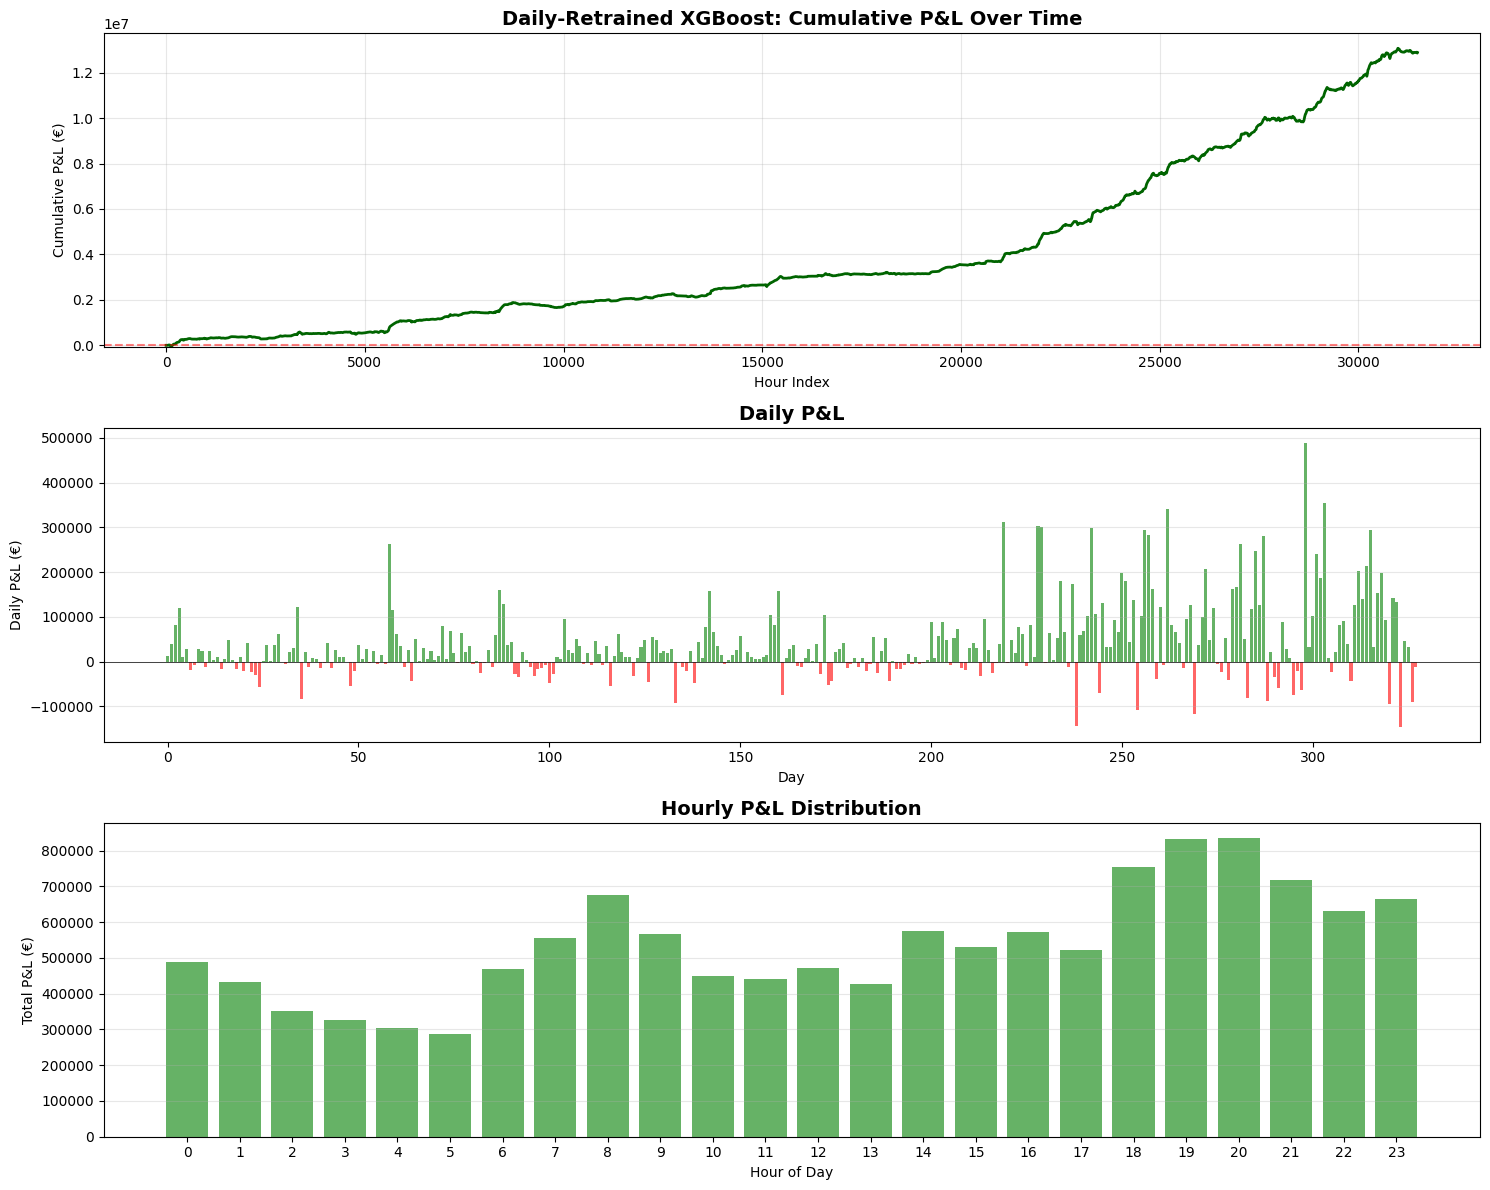


Hourly Breakdown:
--------------------------------------------------------------------------------
Hour      Total PnL   Trades      Avg PnL   Win Rate
--------------------------------------------------------------------------------
   0h  €   487,259     1190  €       409      62.9%
   1h  €   432,473     1200  €       360      61.2%
   2h  €   351,387     1204  €       292      61.2%
   3h  €   327,425     1195  €       274      61.2%
   4h  €   304,344     1165  €       261      61.3%
   5h  €   287,525     1182  €       243      59.7%
   6h  €   468,964     1172  €       400      57.7%
   7h  €   554,724     1218  €       455      62.5%
   8h  €   676,286     1191  €       568      61.6%
   9h  €   565,699     1191  €       475      62.0%
  10h  €   449,685     1187  €       379      57.6%
  11h  €   440,170     1210  €       364      60.5%
  12h  €   471,639     1162  €       406      61.4%
  13h  €   427,809     1217  €       352      63.6%
  14h  €   575,917     1201  €       4

In [36]:
# Strategy 4: Daily-Retrained XGBoost with Time-Weighted Samples
# Train a new model every day on all past data, giving more weight to recent observations

import numpy as np
from xgboost import XGBClassifier
from datetime import datetime

# First, prepare the feature-rich dataset (same as Cell 16)
print("Preparing dataset with enriched features...")

df_daily_ml = df.copy()

# === TEMPORAL FEATURES ===
df_daily_ml['timestamp'] = pd.to_datetime(df_daily_ml['timestamp'])
df_daily_ml['day_of_week'] = df_daily_ml['timestamp'].dt.dayofweek
df_daily_ml['is_weekend'] = (df_daily_ml['day_of_week'] >= 5).astype(int)
df_daily_ml['month'] = df_daily_ml['timestamp'].dt.month
df_daily_ml['day_of_year'] = df_daily_ml['timestamp'].dt.dayofyear
df_daily_ml['hour'] = df_daily_ml['timestamp'].dt.hour

# === RENEWABLE GENERATION FEATURES ===
df_daily_ml['total_renewable_da'] = df_daily_ml['wind_da'] + df_daily_ml['pv_da']

# === PRICE FEATURES ===
id_price_col = 'id_price_h'
df_daily_ml['price_spread'] = df_daily_ml[id_price_col] - df_daily_ml['da_price']

# === LAGGED FEATURES ===
for lag in [1, 2, 7]:  # 1, 2 days and 1 week ago
    lag_hours = lag * 96  # 96 quarter-hours per day
    df_daily_ml[f'da_price_lag_{lag}d'] = df_daily_ml['da_price'].shift(lag_hours)
    df_daily_ml[f'id_price_lag_{lag}d'] = df_daily_ml[id_price_col].shift(lag_hours)
    df_daily_ml[f'spread_lag_{lag}d'] = df_daily_ml['price_spread'].shift(lag_hours)
    df_daily_ml[f'renewable_lag_{lag}d'] = df_daily_ml['total_renewable_da'].shift(lag_hours)

# === ROLLING STATISTICS ===
window = 96  # 24 hours = 96 quarter-hours
df_daily_ml['da_price_mean_24h'] = df_daily_ml['da_price'].rolling(window=window, min_periods=1).mean()
df_daily_ml['da_price_std_24h'] = df_daily_ml['da_price'].rolling(window=window, min_periods=1).std()
df_daily_ml['id_price_mean_24h'] = df_daily_ml[id_price_col].rolling(window=window, min_periods=1).mean()
df_daily_ml['spread_mean_24h'] = df_daily_ml['price_spread'].rolling(window=window, min_periods=1).mean()
df_daily_ml['renewable_mean_24h'] = df_daily_ml['total_renewable_da'].rolling(window=window, min_periods=1).mean()

# === HOUR-OF-DAY STATISTICS ===
hourly_stats = df_daily_ml.groupby('hour').agg({
    'da_price': ['mean', 'std'],
    id_price_col: ['mean', 'std'],
    'price_spread': 'mean'
}).reset_index()
hourly_stats.columns = ['hour', 'da_price_hour_mean', 'da_price_hour_std', 
                        'id_price_hour_mean', 'id_price_hour_std', 'spread_hour_mean']
df_daily_ml = df_daily_ml.merge(hourly_stats, on='hour', how='left')

# Drop rows with NaN
df_daily_ml = df_daily_ml.dropna()

print(f"Dataset shape after feature engineering: {df_daily_ml.shape}")

# Define features (same as Cell 16 - no current prices, no ID forecasts)
feature_columns = [
    'hour', 'day_of_week', 'is_weekend', 'month', 'day_of_year',
    'total_renewable_da', 'wind_da', 'pv_da',
    'da_price_lag_1d', 'id_price_lag_1d', 'spread_lag_1d', 'renewable_lag_1d',
    'da_price_lag_2d', 'id_price_lag_2d', 'spread_lag_2d', 'renewable_lag_2d',
    'da_price_lag_7d', 'id_price_lag_7d', 'spread_lag_7d', 'renewable_lag_7d',
    'da_price_mean_24h', 'da_price_std_24h', 'id_price_mean_24h',
    'spread_mean_24h', 'renewable_mean_24h',
    'da_price_hour_mean', 'spread_hour_mean'
]

print(f"Features: {len(feature_columns)}")

# Initialize tracking variables
daily_trades = []

# Get unique days for daily retraining
unique_days = df_daily_ml['date'].unique()
print(f"\n{'='*80}")
print(f"DAILY-RETRAINED XGBOOST STRATEGY")
print(f"{'='*80}")
print(f"Total days to process: {len(unique_days)}")

# Start trading after sufficient historical data
min_train_days = 30
position_size = 100  # MW

for i, current_day in enumerate(unique_days[min_train_days:], min_train_days):
    # Get all historical data up to (but not including) current day
    train_data = df_daily_ml[df_daily_ml['date'] < current_day].copy()
    
    if len(train_data) < 100:  # Need at least 100 samples
        continue
    
    # Prepare training data
    X_train = train_data[feature_columns]
    y_train = (train_data['price_spread'] > 0).astype(int)  # 1 if positive spread
    
    # Calculate time weights: exponential decay favoring recent data
    # Most recent data gets weight 1.0, oldest data gets weight 0.5
    n_samples = len(train_data)
    # Exponential decay parameter - stronger decay means more weight on recent data
    decay = 0.01  # Adjust this to control how much we favor recent data
    time_weights = np.exp(decay * np.arange(n_samples))
    # Normalize to [0.5, 1.0] range
    time_weights = 0.5 + 0.5 * (time_weights - time_weights.min()) / (time_weights.max() - time_weights.min())
    
    # Train XGBoost model with time-weighted samples
    model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
    
    model.fit(X_train, y_train, sample_weight=time_weights)
    
    # Get current day's data for trading
    test_data = df_daily_ml[df_daily_ml['date'] == current_day].copy()
    
    if len(test_data) == 0:
        continue
    
    X_test = test_data[feature_columns]
    
    # Predict probabilities
    probs = model.predict_proba(X_test)[:, 1]  # Probability of positive spread
    
    # Trading logic: use probability thresholds
    long_threshold = 0.55  # Go long if prob > 0.55
    short_threshold = 0.45  # Go short if prob < 0.45
    
    # Generate trading signals
    test_data['signal'] = 0
    test_data.loc[probs > long_threshold, 'signal'] = 1  # Long position
    test_data.loc[probs < short_threshold, 'signal'] = -1  # Short position
    test_data['prob'] = probs
    
    # Calculate PnL
    test_data['pnl'] = test_data['signal'] * test_data['price_spread'] * position_size
    
    # Store results
    daily_trades.append(test_data)
    
    # Track metrics every 10 days
    if (i - min_train_days) % 10 == 0:
        total_pnl = sum([d['pnl'].sum() for d in daily_trades])
        print(f"Day {i}/{len(unique_days)} ({current_day}): Total PnL = €{total_pnl:,.0f}, "
              f"Training samples = {len(train_data)}, Today's trades = {(test_data['signal'] != 0).sum()}")

# Combine all results
results_df = pd.concat(daily_trades, ignore_index=True)

# Calculate performance metrics
total_pnl = results_df['pnl'].sum()
trades_df = results_df[results_df['signal'] != 0].copy()
n_trades = len(trades_df)
winning_trades = (trades_df['pnl'] > 0).sum()
losing_trades = (trades_df['pnl'] < 0).sum()
win_rate = winning_trades / n_trades if n_trades > 0 else 0

print("\n" + "="*80)
print("STRATEGY 4: DAILY-RETRAINED XGBOOST RESULTS")
print("="*80)
print(f"Total P&L: €{total_pnl:,.2f}")
print(f"Number of trades: {n_trades:,}")
print(f"Winning trades: {winning_trades:,} ({win_rate*100:.1f}%)")
print(f"Losing trades: {losing_trades:,}")
print(f"Average profit per trade: €{total_pnl/n_trades if n_trades > 0 else 0:,.2f}")
print(f"Market coverage: {n_trades/(len(results_df))*100:.1f}%")
print("="*80)

# Calculate cumulative PnL
results_df['cumulative_pnl'] = results_df['pnl'].cumsum()

# Visualizations
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. Cumulative P&L over time
axes[0].plot(results_df.index, results_df['cumulative_pnl'], linewidth=2, color='darkgreen')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title('Daily-Retrained XGBoost: Cumulative P&L Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour Index')
axes[0].set_ylabel('Cumulative P&L (€)')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(bottom=min(0, results_df['cumulative_pnl'].min() * 1.1))

# 2. Daily P&L
daily_pnl = results_df.groupby('date')['pnl'].sum()
colors = ['green' if x > 0 else 'red' for x in daily_pnl]
axes[1].bar(range(len(daily_pnl)), daily_pnl, color=colors, alpha=0.6)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_title('Daily P&L', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Daily P&L (€)')
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Hourly P&L breakdown
hourly_pnl = trades_df.groupby('hour')['pnl'].agg(['sum', 'count', 'mean'])
hourly_pnl['win_rate'] = trades_df.groupby('hour').apply(lambda x: (x['pnl'] > 0).sum() / len(x) * 100)

x_pos = np.arange(24)
colors_hourly = ['green' if x > 0 else 'red' for x in hourly_pnl['sum']]
axes[2].bar(x_pos, hourly_pnl['sum'], color=colors_hourly, alpha=0.6, label='Total PnL')
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_title('Hourly P&L Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Total P&L (€)')
axes[2].set_xticks(x_pos)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Detailed hourly breakdown
print("\nHourly Breakdown:")
print("-" * 80)
print(f"{'Hour':<6} {'Total PnL':>12} {'Trades':>8} {'Avg PnL':>12} {'Win Rate':>10}")
print("-" * 80)
for hour in range(24):
    if hour in hourly_pnl.index:
        print(f"{hour:>4}h  €{hourly_pnl.loc[hour, 'sum']:>10,.0f}  "
              f"{int(hourly_pnl.loc[hour, 'count']):>7}  "
              f"€{hourly_pnl.loc[hour, 'mean']:>10,.0f}  "
              f"{hourly_pnl.loc[hour, 'win_rate']:>8.1f}%")
    else:
        print(f"{hour:>4}h  €{0:>10}  {0:>7}  €{0:>10}  {0:>8.1f}%")
print("-" * 80)

# Signal distribution
print("\nTrading Signal Distribution:")
print("-" * 40)
print(f"Long positions:  {(results_df['signal'] == 1).sum():,}")
print(f"Short positions: {(results_df['signal'] == -1).sum():,}")
print(f"No position:     {(results_df['signal'] == 0).sum():,}")
print("-" * 40)

As a next step, derive and test deterministic trading strategies from the insights generated by XGBoost/other classification models.